# Introduction to MATLAB

## Section 3: A (very brief) introduction to machine learning

As mentioned in the Introduction, one of MATLAB's biggest strengths is its large collection of libraries and its abilities to get code up and running quickly.  As an example, we will perform some basic machine learning with `alexnet`, a neural network that is part of the Neural Network Toolbox.

The Neural Network toolbox doesn't come installed in the base MATLAB installation, so to use `alexnet`, you need to install it.  The easiest way to do it is to just type `alexnet` into your console and follow the instructions:

![First try!](../images/install_alexnet.png)

Once you install it and type `alexnet` again, you'll get a message like the one below.  Install that one too.  

![Second try!](../images/install_alexnet_2.png)

Now, this time, when you type in `alexnet`, you'll see the following.

![Third try!](../images/install_alexnet_3.png)

Great!  You're ready to go!

### Section 3.1: Making predictions

`alexnet` is a neural network that's been trained on hella images and is made to classify images into 1000 different categories.  It takes as input a 227 by 227 pixel image and attempts to classify that image into one of those 1000 categories.  To demonstrate how to work with `alexnet` (and neural networks in general), load in `../data/images/examples/ex1.jpg` and view the image:

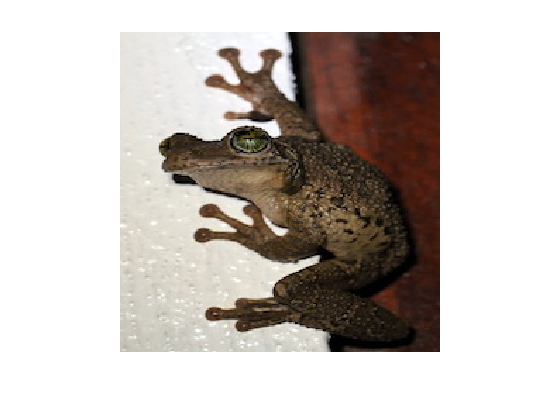

In [3]:
img1 = imread('../data/images/examples/ex1.jpg');
imshow(img1)

Now we're going to load in the `alexnet` neural network and save it to the variable `cnn`:

In [6]:
format compact
cnn = alexnet

cnn = 
  SeriesNetwork with properties:

    Layers: [25x1 nnet.cnn.layer.Layer]


Now that we have the a neural network loaded, we can use the `classify` method to make a prediction about what the image is.  `classify` takes as arguments `net` and `img`, where `net` is the neural network being used to classify the image `img`.  

Let's see what `cnn` thinks our image `img1` is:

In [7]:
img1_pred = classify(cnn, img1)

img1_pred = 
  categorical
     bullfrog 


So `alexnet` thinks that `img1` is of a bullfrog.  Pretty good!  

How confident was `alexnet` in its prediction?  Like other functions we saw earlier, `classify` can actually output more than one value.  In this case, if we save the results of `classify` to `[prediction, score]`, we'll save the confidence `alexnet` has in its prediction to `score`.  For example, to save the prediction and confidence scores for `alexnet`'s prediction on our image, we can do (make sure to put the `;` at the end of the next line):

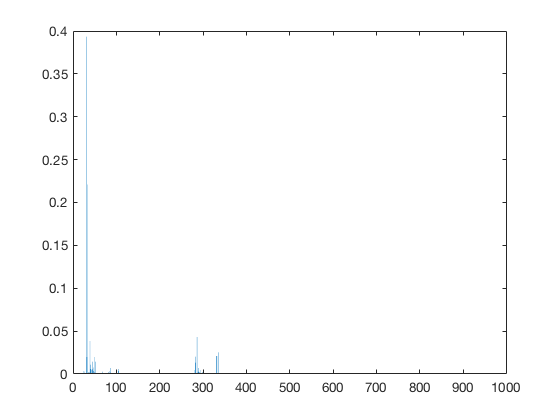

In [13]:
[img1_pred, img1_conf] = classify(cnn, img1);
bar(img1_conf)

There are a lot of really small numbers.  Why?

Let's fix this so that only the most "significant" predictions are indicated:

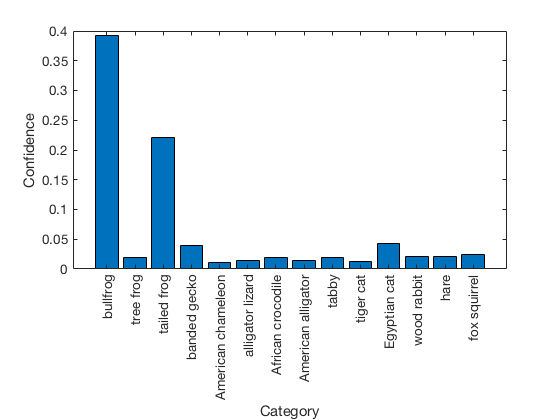

In [19]:
sig_threshold = 0.01;
sig_scores = img1_conf > sig_threshold;
bar(img1_conf(sig_scores))
categories = cnn.Layers(end).ClassNames;
xticklabels(categories(sig_scores))
xtickangle(90)
xlabel("Category")
ylabel("Confidence")

So it looked like `alexnet` was pretty confident that it was some sort of frog.  All in all, a solid prediction.  Let's repeat the process on another image:

> In images.internal.initSize (line 71)
  In imshow (line 336)


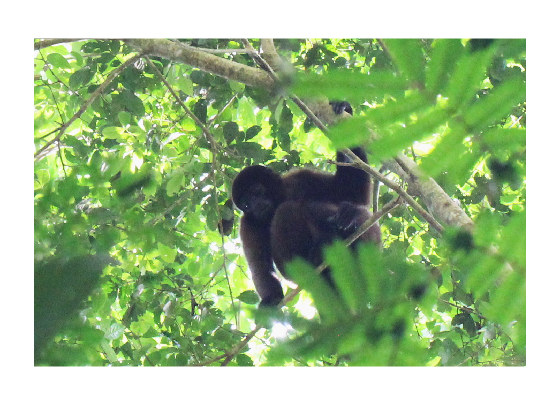

In [20]:
img2 = imread('../data/images/examples/ex2.jpg');
imshow(img2)

In [ ]:
[img2_pred, img2_conf] = classify(cnn, img2);